# ****Prerequisites****


In [7]:
!pip install torch torchaudio matplotlib --quiet

 # **1. Load & Inspect an Example Clip**


In [10]:
# Downloading a test file
!wget https://facebookresearch.github.io/denoiser/audio/noisy/alex_noisy.mp3

--2025-07-02 14:41:06--  https://facebookresearch.github.io/denoiser/audio/noisy/alex_noisy.mp3
Resolving facebookresearch.github.io (facebookresearch.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to facebookresearch.github.io (facebookresearch.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 339840 (332K) [audio/mp3]
Saving to: ‘alex_noisy.mp3’

alex_noisy.mp3      100%[===================>] 331.88K  --.-KB/s    in 0.006s  

2025-07-02 14:41:07 (55.2 MB/s) - ‘alex_noisy.mp3’ saved [339840/339840]



In [11]:
import torchaudio
from torchaudio.utils import download_asset
import matplotlib.pyplot as plt

# Torchaudio ships a tiny speech sample – "Yes" from the SpeechCommands dataset
waveform, sample_rate = torchaudio.load('alex_noisy.mp3')
print(f"Shape: {waveform.shape}  |  Sample rate: {sample_rate} Hz")
print(f"Dtype: {waveform.dtype}  |  Min/Max: {waveform.min():.3f}/{waveform.max():.3f}")

Shape: torch.Size([1, 269973])  |  Sample rate: 16000 Hz
Dtype: torch.float32  |  Min/Max: -0.885/0.871


## The number of channels is the first dimension of the waveform tensor

In [ ]:
num_channels = waveform.shape[0]
print(f"The audio clip contains {num_channels} channel(s).")

## Calculate its duration in seconds (waveform.shape[-1] / sample_rate).

In [18]:

print(waveform.shape[-1]/sample_rate)

16.8733125


# Below we can display and play the audio file to confirm its duration

In [21]:
from IPython import display as disp

disp.Audio(waveform, rate=sample_rate)

# **2. Visualise the Waveform & Amplitude Levels**

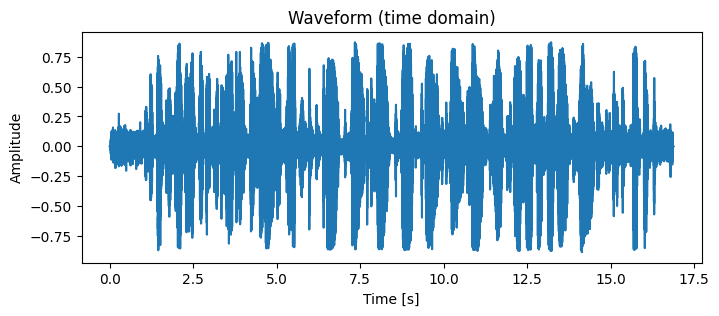

RMS =-15.4 dBFS
Peak=-1.1 dBFS


/tmp/ipython-input-19-1399244819.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f"RMS ={20*np.log10(rms):.1f} dBFS\nPeak={20*np.log10(peak):.1f} dBFS")


In [19]:
import torch
import numpy as np

time = torch.arange(waveform.shape[-1]) / sample_rate
plt.figure(figsize=(8,3))
plt.plot(time, waveform.t().numpy())
plt.title("Waveform (time domain)")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude")
plt.show()

rms = waveform.pow(2).mean().sqrt()
peak = waveform.abs().max()
print(f"RMS ={20*np.log10(rms):.1f} dBFS\nPeak={20*np.log10(peak):.1f} dBFS")

# **3. Resample & Hear the Difference (Sampling‑Rate Experiment)**

In [41]:
low_sr = 8000      # telephone‑quality
hi_sr  = 44000     # high(er) fidelity
resample_low = torchaudio.transforms.Resample(sample_rate, low_sr)
resample_hi  = torchaudio.transforms.Resample(sample_rate, hi_sr)

audio_low = resample_low(waveform)
audio_hi  = resample_hi(waveform)
print(audio_low.shape, audio_hi.shape)

torch.Size([1, 134987]) torch.Size([1, 742426])


## Display audio files with different sampling rates to see the difference

In [42]:
# @title Audio file with sampling rate 44000Hz
from IPython import display as disp

disp.Audio(audio_hi, rate=hi_sr)

In [43]:
# @title Audio file with sampling rate 8000Hz
disp.Audio(audio_low, rate=low_sr)

In [44]:
# @title Original Audio file with sampling rate 16000Hz
disp.Audio(waveform, rate=sample_rate)

## **5. Bit‑Depth Experiment (Quantization)**

In [52]:
def quantise(x, bits):
    qlevels = 2**bits
    x_q = torch.round((x + 1)*((qlevels-1)/2)).clamp(0, qlevels-1)
    x_q = (x_q*2/(qlevels-1)) - 1
    return x_q

audio_8bit = quantise(waveform, bits=32)
noise = waveform - audio_8bit
print("Quantisation‑noise RMS:", noise.square().mean().sqrt())

Quantisation‑noise RMS: tensor(2.7553e-08)


In [54]:
disp.Audio(audio_8bit, rate=sample_rate)

## How many extra dB of dynamic range do you gain moving from 8‑bit to 16‑bit?

From 8-bit to 16-bit, the number of possible amplitude levels goes from 2<sup>8</sup> = 256 to 2<sup>16</sup> = 65536.

In terms of dynamic range, this is a difference of:

20 * log10(65536 / 256) = 20 * log10(256) ≈ 48 dB.

So you gain approximately 48 dB of dynamic range when moving from 8-bit to 16-bit audio.